In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
sns.set_context("notebook", font_scale=1.25)

In [3]:
def parse_gtime(filename):
    """
    Parses a gtime output file to extract elapsed time and maximum memory usage.

    Args:
        filename (str): Path to the gtime output file.

    Returns:
        tuple: A tuple containing:
               - time (str): Elapsed wall clock time in the format "h:mm:ss" or "m:ss".
               - memory (int): Maximum resident set size in kilobytes.
    """

    def convert_to_seconds(time_str):
        """
        Converts a time string in the format "h:mm:ss" or "m:ss" to seconds.
    
        Args:
            time_str (str): Time string in "h:mm:ss" or "m:ss" format.
    
        Returns:
            float: Time in seconds.
        """
        parts = time_str.split(":")
        if len(parts) == 3:  # Format: h:mm:ss
            hours, minutes, seconds = map(float, parts)
            return hours * 3600 + minutes * 60 + seconds
        elif len(parts) == 2:  # Format: m:ss
            minutes, seconds = map(float, parts)
            return minutes * 60 + seconds
        elif len(parts) == 1: # just seconds
            return float(parts[0])
        else:
            raise ValueError(f"Unrecognized time format: {time_str}")
            
    time = None
    memory = None

    with open(filename, 'r') as file:
        for line in file:
            # Extract elapsed time
            if line.strip().startswith("Elapsed (wall clock) time"):
                time_str = line.strip().strip("Elapsed (wall clock) time (h:mm:ss or m:ss):")
                time = convert_to_seconds(time_str)

            # Extract maximum memory usage
            if line.strip().startswith("Maximum resident set size"):
                memory = int(line.split(":")[-1].strip())

    return time, memory

In [4]:
def extract_matrices(input_file):
    """
    Extracts variant read count matrix (V) and total read count matrix (D) from a TSV file.

    Args:
        input_file (str): Path to the input TSV file.

    Returns:
        tuple: A tuple containing:
               - V (numpy.ndarray): A 2D array of variant read counts (samples x mutations).
               - D (numpy.ndarray): A 2D array of total read counts (samples x mutations).
    """
    # Read the TSV file into a DataFrame
    df = pd.read_csv(input_file, sep='\t')

    # Sort the DataFrame by sample_index and mutation_index
    df = df.sort_values(by=['sample_index', 'mutation_index'])

    # Pivot the DataFrame to create matrices
    V = df.pivot(index='sample_index', columns='mutation_index', values='var').values
    D = df.pivot(index='sample_index', columns='mutation_index', values='depth').values

    return V, D

In [5]:
def extract_frequency_matrix(input_file):
    """
    Extracts the frequency matrix (F) from a TSV file, ensuring frequency columns are sorted correctly.

    Args:
        input_file (str): Path to the input TSV file.

    Returns:
        numpy.ndarray: A 2D array of frequencies (samples x mutations).
    """
    # Read the TSV file into a DataFrame
    df = pd.read_csv(input_file, sep='\t')

    # Extract columns starting with 'f_'
    f_columns = [col for col in df.columns if col.startswith('f_')]

    # Sort frequency columns in the correct order
    f_columns_sorted = sorted(f_columns, key=lambda x: (int(x.split('_')[1]), int(x.split('_')[2])))

    # Extract the sorted frequency columns
    F = df[f_columns_sorted].values

    # Reshape the frequency matrix to (samples x mutations)
    num_samples = max(int(col.split('_')[1]) for col in f_columns_sorted) + 1
    num_mutations = max(int(col.split('_')[2]) for col in f_columns_sorted) + 1
    F = F.reshape(-1, num_samples, num_mutations)

    # Take the first row
    F = F[0]

    return F

In [6]:
def extract_number_trees(input_file):
    """
    Extracts the number of trees

    Args:
        input_file (str): Path to the input TSV file.

    Returns:
        int: Number of trees.
    """
    # Read the TSV file into a DataFrame
    df = pd.read_csv(input_file, sep='\t')
    return df.shape[0]

In [7]:
def binomial_log_likelihood(F, V, D, eps=1e-10):
    """
    Computes the binomial log-likelihood given frequency, variant, and total read count matrices.

    Args:
        F (numpy.ndarray): Frequency matrix (samples x mutations).
        V (numpy.ndarray): Variant read count matrix (samples x mutations).
        D (numpy.ndarray): Total read count matrix (samples x mutations).
        eps (float): A small value to avoid log(0). Default is 1e-10.

    Returns:
        float: The binomial log-likelihood.
    """
    # Ensure F is within valid range [0, 1]
    F = np.clip(F, eps, 1 - eps)

    # Compute the log-likelihood
    log_likelihood = np.sum(
        np.where(V > 0, V * np.log(F), 0) +  # Handle V = 0
        np.where(D - V > 0, (D - V) * np.log(1 - F), 0)  # Handle D - V = 0
    )

    return log_likelihood

In [125]:
def determine_gt_trees():
    d = {n : {} for n in [20,50]}
    for n in [20,50]:
        for s in range(1,21):
            for filename in glob.glob("../data/sims/n%d_m10_s%d.tree" % (n,s)):
                with open(filename, "r") as f:
                    line = f.readline()
                    ss = line.rstrip("))").split("),")
                    ss = [sss[2:].split(', ') for sss in ss]
                    sset = set()
                    for l in ss:
                        sset.add((int(l[0]),int(l[1])))
                    d[n][s] = sset

    return d
    
gt_trees = determine_gt_trees()

In [131]:
def extract_inferred_full_trees(gt_trees):
    def transitive_closure(relation):
        elements = {x for pair in relation for x in pair}
        elements = sorted(elements)
        size = len(elements)
        element_to_index = {elem: idx for idx, elem in enumerate(elements)}
        
        # Initialize adjacency matrix
        matrix = [[False] * size for _ in range(size)]
        for a, b in relation:
            i = element_to_index[a]
            j = element_to_index[b]
            matrix[i][j] = True
        
        # Warshall's algorithm
        for k in range(size):
            for i in range(size):
                for j in range(size):
                    matrix[i][j] = matrix[i][j] or (matrix[i][k] and matrix[k][j])
        
        # Convert back to tuples
        result = set()
        for i in range(size):
            for j in range(size):
                if matrix[i][j]:
                    result.add((elements[i], elements[j]))
        
        return result
    
    rows = []
    for n in [20,50]:
        for s in range(1,21):
            for filename in glob.glob("../data/sims/n%d_m10_s%d.tsv" % (n,s)):
                basename = os.path.basename(filename).rstrip(".tsv")
                for b in [1, 10, 50, 100]:
                    filename = "sims_infer_full_trees_fastppm_small_expand/" + basename + "_b" + str(b) + ".tsv"
                    with open(filename, "r") as f:
                        f.readline()
                        line = f.readline()
                        tree = list(zip(list(map(int, line.split("\t")[2:2+n])),range(n)))
                        new_tree = set()
                        for (src, tgt) in tree:
                            if src != -1:
                                new_tree.add((src, tgt))
                        ad_gt_tree = transitive_closure(gt_trees[n][s])
                        ad_new_tree = transitive_closure(new_tree)
                        PC = len(set.symmetric_difference(gt_trees[n][s], new_tree)) / len(set.union(gt_trees[n][s], new_tree))
                        AD = len(set.symmetric_difference(ad_gt_tree, ad_new_tree)) / len(set.union(ad_gt_tree, ad_new_tree))
                        recall = len(set.intersection(gt_trees[n][s], new_tree)) / (n - 1)

                        row = {'n' : n, 'beam-width' : b, 'instance' : basename, 'method' : "sapling-small", 'PC' : PC, 'recall' : recall, 'AD' : AD}
                        rows.append(row)

                    filename = "sims_infer_full_trees_orchard/" + basename + ".ssm_k" + str(b) + ".tsv"
                    with open(filename, "r") as f:
                        f.readline()
                        line = f.readline()
                        tree = list(zip(list(map(int, line.split("\t")[2:2+n])),range(n)))
                        new_tree = set()
                        for (src, tgt) in tree:
                            if src != -1:
                                new_tree.add((src, tgt))
                        ad_gt_tree = transitive_closure(gt_trees[n][s])
                        ad_new_tree = transitive_closure(new_tree)
                        PC = len(set.symmetric_difference(gt_trees[n][s], new_tree)) / len(set.union(gt_trees[n][s], new_tree))
                        AD = len(set.symmetric_difference(ad_gt_tree, ad_new_tree)) / len(set.union(ad_gt_tree, ad_new_tree))
                        recall = len(set.intersection(gt_trees[n][s], new_tree)) / (n - 1)

                        row = {'n' : n, 'beam-width' : b, 'instance' : basename, 'method' : "orchard", 'PC' : PC, 'recall' : recall, 'AD' : AD}
                        rows.append(row)
    return rows
    
df_full_trees_PC = pd.DataFrame(extract_inferred_full_trees(gt_trees))

sims_infer_full_trees_fastppm_small_expand/n20_m10_s1_b1.tsv
sims_infer_full_trees_fastppm_small_expand/n20_m10_s1_b10.tsv
sims_infer_full_trees_fastppm_small_expand/n20_m10_s1_b50.tsv
sims_infer_full_trees_fastppm_small_expand/n20_m10_s1_b100.tsv
sims_infer_full_trees_fastppm_small_expand/n20_m10_s2_b1.tsv
sims_infer_full_trees_fastppm_small_expand/n20_m10_s2_b10.tsv
sims_infer_full_trees_fastppm_small_expand/n20_m10_s2_b50.tsv
sims_infer_full_trees_fastppm_small_expand/n20_m10_s2_b100.tsv
sims_infer_full_trees_fastppm_small_expand/n20_m10_s3_b1.tsv
sims_infer_full_trees_fastppm_small_expand/n20_m10_s3_b10.tsv
sims_infer_full_trees_fastppm_small_expand/n20_m10_s3_b50.tsv
sims_infer_full_trees_fastppm_small_expand/n20_m10_s3_b100.tsv
sims_infer_full_trees_fastppm_small_expand/n20_m10_s4_b1.tsv
sims_infer_full_trees_fastppm_small_expand/n20_m10_s4_b10.tsv
sims_infer_full_trees_fastppm_small_expand/n20_m10_s4_b50.tsv
sims_infer_full_trees_fastppm_small_expand/n20_m10_s4_b100.tsv
sims_inf

In [190]:
# handle infer_full_trees experiments
rows = []
for n in [20,50,100]:
    for filename in glob.glob("../data/sims/n%d*.tsv" % n):
        V, D = extract_matrices(filename)
        basename = os.path.basename(filename).rstrip(".tsv")
    
        for b in [1, 10, 50, 100]:
            # F = extract_frequency_matrix("sims_infer_full_trees_fastppm_big_expand2/" + basename + "_b" + str(b) + ".tsv")
            # llh = binomial_log_likelihood(F, V, D)
            # nr_trees = extract_number_trees("sims_infer_full_trees_fastppm_big_expand2/" + basename + "_b" + str(b) + ".tsv")
            # time, memory = parse_gtime("sims_infer_full_trees_fastppm_big_expand2/" + basename + "_b" + str(b) + ".time")
            # row = {'n' : n, 'trees' : nr_trees, 'beam-width' : b, 'instance' : basename, 'llh' : llh, 'method' : "sapling-big", 'time' : time, 'memory' : memory}
            # rows.append(row)
    
            F = extract_frequency_matrix("sims_infer_full_trees_fastppm_small_expand/" + basename + "_b" + str(b) + ".tsv")
            llh = binomial_log_likelihood(F, V, D)
            nr_trees = extract_number_trees("sims_infer_full_trees_fastppm_small_expand/" + basename + "_b" + str(b) + ".tsv")
            time, memory = parse_gtime("sims_infer_full_trees_fastppm_small_expand/" + basename + "_b" + str(b) + ".time")
            row = {'n' : n, 'trees' : nr_trees, 'beam-width' : b, 'instance' : basename, 'llh' : llh, 'method' : "sapling-small", 'time' : time, 'memory' : memory}
            rows.append(row)
    
            F = extract_frequency_matrix("sims_infer_full_trees_orchard/" + basename + ".ssm_k" + str(b) + ".tsv")
            llh = binomial_log_likelihood(F, V, D)
            nr_trees = extract_number_trees("sims_infer_full_trees_orchard/" + basename + ".ssm_k" + str(b) + ".tsv")
            time, memory = parse_gtime("sims_infer_full_trees_orchard/" + basename + ".ssm_k" + str(b) + ".time")
            row = {'n' : n, 'trees' : nr_trees, 'beam-width' : b, 'instance' : basename, 'llh' : llh, 'method' : "orchard", 'time' : time, 'memory' : memory}
            rows.append(row)

df_full_trees = pd.DataFrame(rows)

In [108]:
df_full_trees = pd.read_csv("sims_infer_full_trees.csv")

In [192]:
df_full_trees[df_full_trees['method'] == 'sapling-big']

,n,trees,beam-width,instance,llh,method,time,memory
0,20,1,1,n20_m10_s5,-5999.321612,sapling-big,0.61,76240
3,20,10,10,n20_m10_s5,-5999.321612,sapling-big,3.11,93104
6,20,50,50,n20_m10_s5,-5999.312781,sapling-big,11.86,158160
9,20,100,100,n20_m10_s5,-5999.312781,sapling-big,23.85,227440
12,20,1,1,n20_m10_s4,-5001.468461,sapling-big,0.81,76720
...,...,...,...,...,...,...,...,...
705,100,100,100,n100_m10_s3,-13050.899538,sapling-big,4098.00,3362800
708,100,1,1,n100_m10_s17,-14817.671704,sapling-big,32.83,124400
711,100,10,10,n100_m10_s17,-14815.243977,sapling-big,330.49,416768
714,100,50,50,n100_m10_s17,-14808.213388,sapling-big,1640.35,1572480


In [193]:
df_full_trees.to_csv("sims_infer_full_trees.csv")

In [194]:
df_full_trees

,n,trees,beam-width,instance,llh,method,time,memory
0,20,1,1,n20_m10_s5,-5999.321612,sapling-big,0.61,76240
1,20,1,1,n20_m10_s5,-5999.321612,sapling-small,0.43,74576
2,20,1,1,n20_m10_s5,-6007.779159,orchard,1.55,104656
3,20,10,10,n20_m10_s5,-5999.321612,sapling-big,3.11,93104
4,20,10,10,n20_m10_s5,-5999.321612,sapling-small,2.07,88080
...,...,...,...,...,...,...,...,...
715,100,50,50,n100_m10_s17,-14808.213388,sapling-small,1438.71,1309472
716,100,50,50,n100_m10_s17,-14883.139691,orchard,313.13,124848
717,100,100,100,n100_m10_s17,-14805.573894,sapling-big,3409.61,3140016
718,100,100,100,n100_m10_s17,-14805.573894,sapling-small,2894.49,2466208


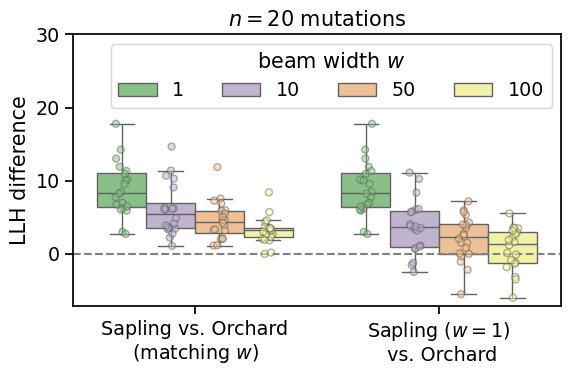

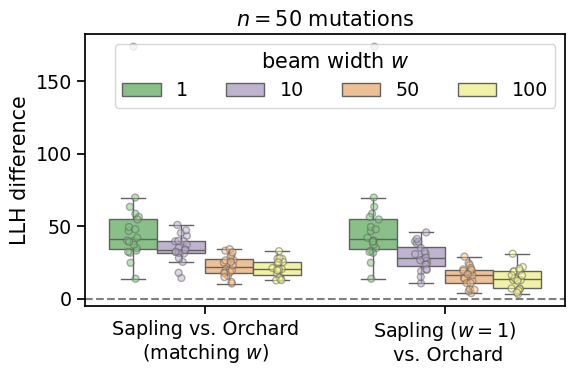

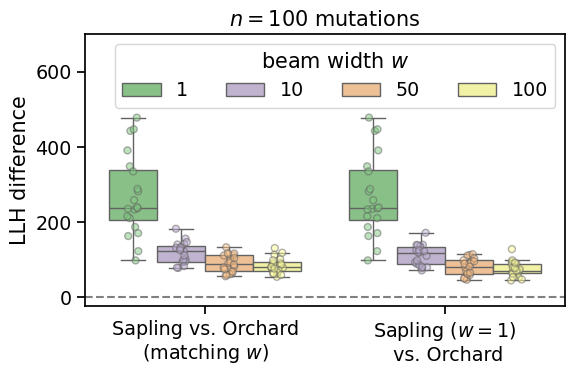

In [238]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

for n in [20, 50, 100]:
    # Filter the dataframe for the current value of n
    df = df_full_trees[(df_full_trees["n"] == n)]
    
    # Step 1: Filter rows where method is 'sapling-small' and beam-width == 1
    sapling_small_beam1 = df[(df['method'] == 'sapling-small') & (df['beam-width'] == 1)]
    
    # Step 2: Filter rows where method is 'orchard'
    orchard_methods = df[df['method'] == 'orchard']
    
    # Step 3: Merge the two dataframes on 'instance' for the first comparison
    merged_beam1_vs_orchard = pd.merge(
        sapling_small_beam1[['instance', 'llh']],
        orchard_methods[['instance', 'beam-width', 'llh']],
        on='instance',
        suffixes=('_sapling_small_beam1', '_orchard')
    )
    
    # Step 4: Compute the llh difference for the first comparison
    merged_beam1_vs_orchard['llh_diff'] = merged_beam1_vs_orchard['llh_sapling_small_beam1'] - merged_beam1_vs_orchard['llh_orchard']
    merged_beam1_vs_orchard['comparison'] = 'Sapling ($w=1$)\n vs. Orchard'
    
    # Step 5: Compare sapling-small vs. orchard with matching beamwidths
    sapling_small_all_beamwidths = df[df['method'] == 'sapling-small']
    orchard_all_beamwidths = df[df['method'] == 'orchard']
    
    # Merge on both 'instance' and 'beam-width' for the second comparison
    merged_matching_beamwidths = pd.merge(
        sapling_small_all_beamwidths[['instance', 'beam-width', 'llh']],
        orchard_all_beamwidths[['instance', 'beam-width', 'llh']],
        on=['instance', 'beam-width'],
        suffixes=('_sapling_small', '_orchard')
    )
    
    # Compute the llh difference for the second comparison
    merged_matching_beamwidths['llh_diff'] = merged_matching_beamwidths['llh_sapling_small'] - merged_matching_beamwidths['llh_orchard']
    merged_matching_beamwidths['comparison'] = 'Sapling vs. Orchard\n(matching $w$)'
    
    # Combine the two comparison dataframes
    combined = pd.concat([merged_matching_beamwidths, merged_beam1_vs_orchard])
    
    # Plot
    fig, ax = plt.subplots(figsize=(6, 4))
    
    sns.boxplot(data=combined, 
                ax=ax, x="comparison", 
                y='llh_diff', hue='beam-width', showfliers=False, palette="Accent")
    sns.stripplot(data=combined,
                  ax=ax, 
                  y='llh_diff', hue='beam-width', dodge=True, x="comparison", alpha=.5, linewidth=1, palette="Accent")
    
    # Add labels and title
    plt.xlabel('')
    plt.ylabel('LLH difference')
    # plt.yscale('symlog')
    plt.title(f'$n = {n}$ mutations')
    plt.axhline(y=0, linestyle='--', color='gray')
    
    # Adjust legend
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[:len(labels)//2], labels[:len(labels)//2], title='beam width $w$', ncols=4)
    if n == 20:
        ax.set_ylim((None, 30))
    elif n == 100:
        ax.set_ylim((None, 700))
    
    plt.tight_layout()
    plt.savefig(f"LLH_Sapling_vs_Orchard_Combined_n{n}.pdf")
    # plt.close()

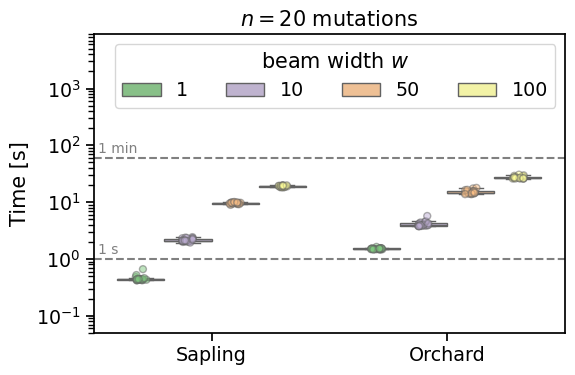

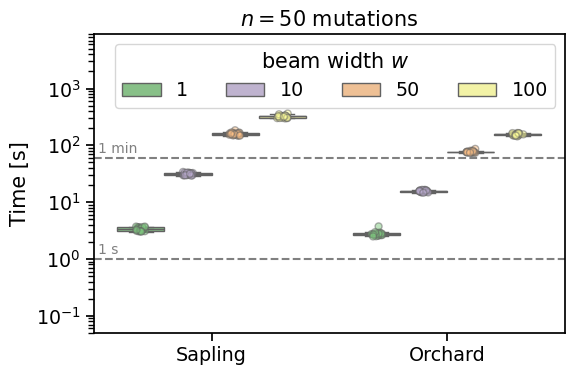

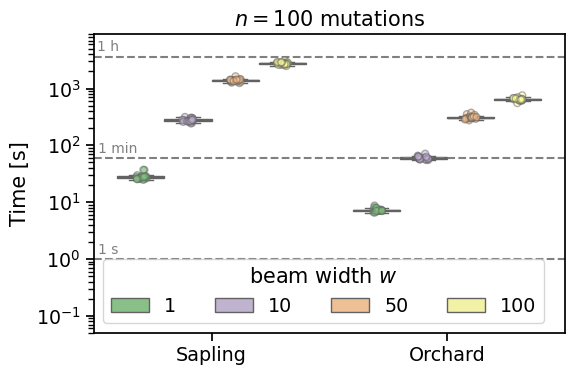

In [277]:
for n in [20,50,100]:
    df_filtered = df_full_trees[(df_full_trees['n'] == n) & (df_full_trees['method'].isin(['sapling-small', 'orchard']))]
    df_filtered = df_filtered.replace(
        {'method': {'sapling-small': 'Sapling', 'sapling-big' : 'Sapling (big)', 'orchard': 'Orchard'}}
    )

    fig, ax = plt.subplots(figsize=(6, 4))
    
    sns.boxplot(data=df_filtered, ax=ax, x='method', y='time', hue='beam-width', showfliers=False, palette="Accent")
    sns.stripplot(data=df_filtered, ax=ax, x='method', y='time', hue='beam-width', palette="Accent",
                  dodge=True, alpha=.5, linewidth=1)
    
    # Add labels and title
    ax.set_xlabel('')
    ax.set_ylabel('Time [s]')
    ax.set_title('$n = %d$ mutations' % n)
    ax.set_yscale('log')  
    ax.set_ylim((5e-2, 9e3))

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[:len(labels)//2], labels[:len(labels)//2], title='beam width $w$', ncols=4)
    plt.axhline(y=1, color='gray', linestyle='--')
    plt.text(x=-.44, y=1.1, s='1 s', color='gray', ha='center', va='bottom',fontsize='10')
    plt.axhline(y=60, color='gray', linestyle='--')
    plt.text(x=-.4, y=65.1, s='1 min', color='gray', ha='center', va='bottom',fontsize='10')

    if n==100:
        plt.axhline(y=3600, color='gray', linestyle='--')
        plt.text(x=-0.44, y=4000, s='1 h', color='gray', ha='center', va='bottom',fontsize='10')
    
    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig("time_full_trees_n%d.pdf" % n)

In [290]:
np.median(df_full_trees[(df_full_trees['method'] == 'sapling-small') & (df_full_trees['n'] == 100) & (df_full_trees['beam-width'] == 1)].time)

np.float64(27.494999999999997)

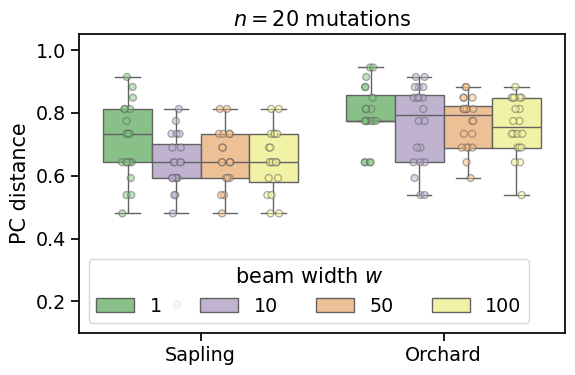

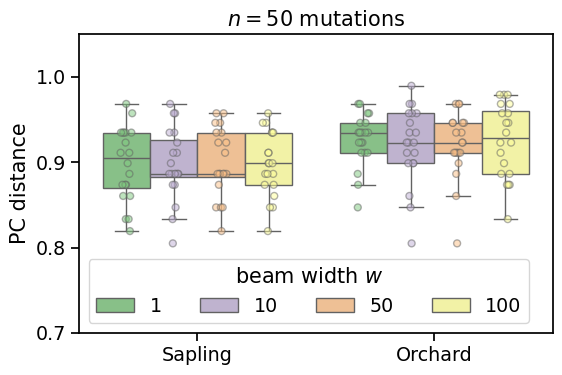

In [161]:
for n in [20,50]:
    df_filtered = df_full_trees_PC[(df_full_trees_PC['n'] == n) & (df_full_trees_PC['method'].isin(['sapling-small', 'orchard']))]
    df_filtered = df_filtered.replace(
        {'method': {'sapling-small': 'Sapling', 'sapling-big' : 'Sapling (big)', 'orchard': 'Orchard'}}
    )

    fig, ax = plt.subplots(figsize=(6, 4))
    
    sns.boxplot(data=df_filtered, ax=ax, x='method', y='PC', hue='beam-width', showfliers=False, palette="Accent")
    sns.stripplot(data=df_filtered, ax=ax, x='method', y='PC', hue='beam-width', palette="Accent",
                  dodge=True, alpha=.5, linewidth=1)
    
    # Add labels and title
    ax.set_xlabel('')
    ax.set_ylabel('PC distance')
    ax.set_title('$n = %d$ mutations' % n)
    # ax.set_yscale('log')  
    # ax.set_ylim((-1e-2, 1.05))

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[:len(labels)//2], labels[:len(labels)//2], title='beam width $w$', ncols=4)

    if n == 20:
        ax.set_ylim((0.1, 1.05))
    if n == 50:
        ax.set_ylim((0.7, 1.05))
    
    
    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(f"PC_Sapling_vs_Orchard_Combined_n{n}.pdf")


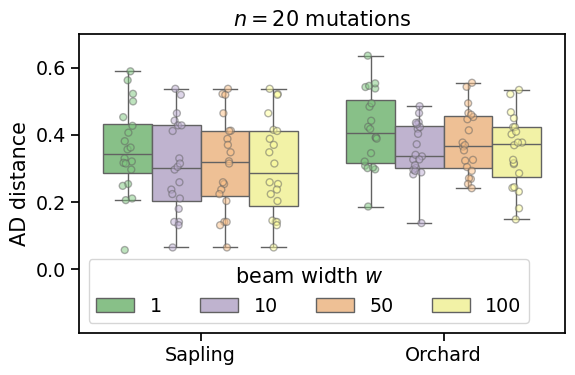

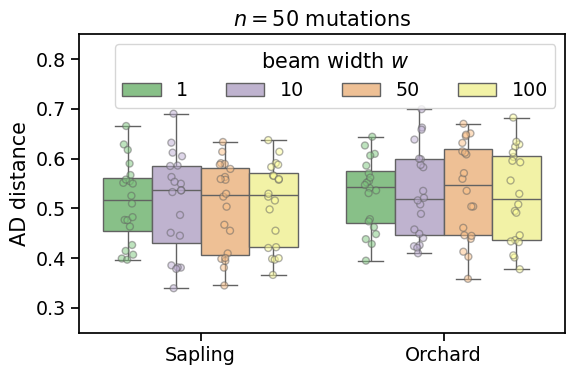

In [155]:
for n in [20,50]:
    df_filtered = df_full_trees_PC[(df_full_trees_PC['n'] == n) & (df_full_trees_PC['method'].isin(['sapling-small', 'orchard']))]
    df_filtered = df_filtered.replace(
        {'method': {'sapling-small': 'Sapling', 'sapling-big' : 'Sapling (big)', 'orchard': 'Orchard'}}
    )

    fig, ax = plt.subplots(figsize=(6, 4))
    
    sns.boxplot(data=df_filtered, ax=ax, x='method', y='AD', hue='beam-width', showfliers=False, palette="Accent")
    sns.stripplot(data=df_filtered, ax=ax, x='method', y='AD', hue='beam-width', palette="Accent",
                  dodge=True, alpha=.5, linewidth=1)
    
    # Add labels and title
    ax.set_xlabel('')
    ax.set_ylabel('AD distance')
    ax.set_title('$n = %d$ mutations' % n)
    # ax.set_yscale('log')  
    # ax.set_ylim((-1e-2, 1.05))

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[:len(labels)//2], labels[:len(labels)//2], title='beam width $w$', ncols=4)

    if n == 20:
        ax.set_ylim((-0.19, 0.7))
    if n == 50:
        ax.set_ylim((0.25, .85))
    
    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(f"AD_Sapling_vs_Orchard_Combined_n{n}.pdf")

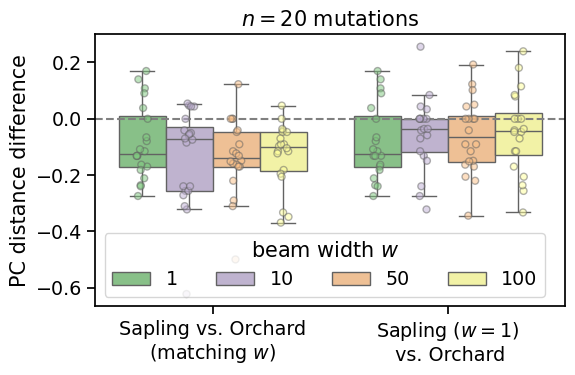

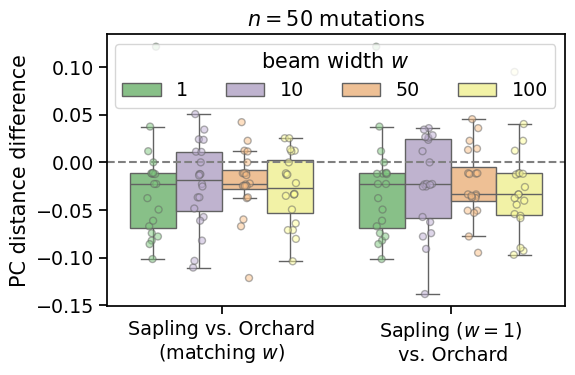

In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

for n in [20, 50]:
    # Filter the dataframe for the current value of n
    df = df_full_trees_PC[(df_full_trees_PC["n"] == n)]
    
    # Step 1: Filter rows where method is 'sapling-small' and beam-width == 1
    sapling_small_beam1 = df[(df['method'] == 'sapling-small') & (df['beam-width'] == 1)]
    
    # Step 2: Filter rows where method is 'orchard'
    orchard_methods = df[df['method'] == 'orchard']
    
    # Step 3: Merge the two dataframes on 'instance' for the first comparison
    merged_beam1_vs_orchard = pd.merge(
        sapling_small_beam1[['instance', 'PC']],
        orchard_methods[['instance', 'beam-width', 'PC']],
        on='instance',
        suffixes=('_sapling_small_beam1', '_orchard')
    )
    
    # Step 4: Compute the llh difference for the first comparison
    merged_beam1_vs_orchard['PC_diff'] = merged_beam1_vs_orchard['PC_sapling_small_beam1'] - merged_beam1_vs_orchard['PC_orchard']
    merged_beam1_vs_orchard['comparison'] = 'Sapling ($w=1$)\n vs. Orchard'
    
    # Step 5: Compare sapling-small vs. orchard with matching beamwidths
    sapling_small_all_beamwidths = df[df['method'] == 'sapling-small']
    orchard_all_beamwidths = df[df['method'] == 'orchard']
    
    # Merge on both 'instance' and 'beam-width' for the second comparison
    merged_matching_beamwidths = pd.merge(
        sapling_small_all_beamwidths[['instance', 'beam-width', 'PC']],
        orchard_all_beamwidths[['instance', 'beam-width', 'PC']],
        on=['instance', 'beam-width'],
        suffixes=('_sapling_small', '_orchard')
    )
    
    # Compute the llh difference for the second comparison
    merged_matching_beamwidths['PC_diff'] = merged_matching_beamwidths['PC_sapling_small'] - merged_matching_beamwidths['PC_orchard']
    merged_matching_beamwidths['comparison'] = 'Sapling vs. Orchard\n(matching $w$)'
    
    # Combine the two comparison dataframes
    combined = pd.concat([merged_matching_beamwidths, merged_beam1_vs_orchard])
    
    # Plot
    fig, ax = plt.subplots(figsize=(6, 4))
    
    sns.boxplot(data=combined, 
                ax=ax, x="comparison", 
                y='PC_diff', hue='beam-width', showfliers=False, palette="Accent")
    sns.stripplot(data=combined,
                  ax=ax, 
                  y='PC_diff', hue='beam-width', dodge=True, x="comparison", alpha=.5, linewidth=1, palette="Accent")
    
    # Add labels and title
    plt.xlabel('')
    plt.ylabel('PC distance difference')
    # plt.yscale('symlog')
    plt.title(f'$n = {n}$ mutations')
    plt.axhline(y=0, linestyle='--', color='gray')
    
    # Adjust legend
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[:len(labels)//2], labels[:len(labels)//2], title='beam width $w$', ncols=4)
    # if n == 20:
        # ax.set_ylim((-0.9, 0.9))
    # if n == 50:
        # ax.set_ylim((-0.25, .25))
    
    plt.tight_layout()
    plt.savefig(f"PC_Diff_Sapling_vs_Orchard_Combined_n{n}.pdf")
    # plt.close()

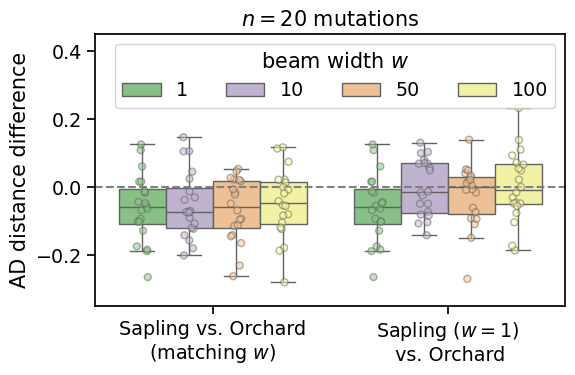

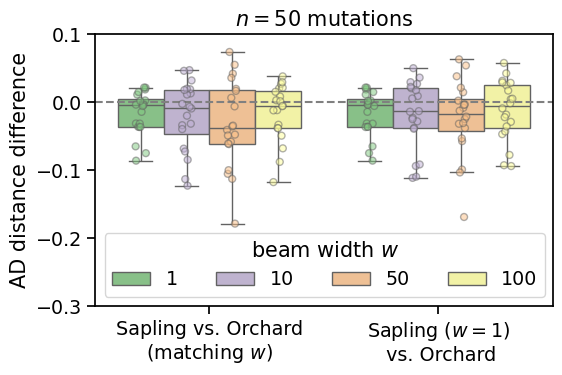

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

for n in [20, 50]:
    # Filter the dataframe for the current value of n
    df = df_full_trees_PC[(df_full_trees_PC["n"] == n)]
    
    # Step 1: Filter rows where method is 'sapling-small' and beam-width == 1
    sapling_small_beam1 = df[(df['method'] == 'sapling-small') & (df['beam-width'] == 1)]
    
    # Step 2: Filter rows where method is 'orchard'
    orchard_methods = df[df['method'] == 'orchard']
    
    # Step 3: Merge the two dataframes on 'instance' for the first comparison
    merged_beam1_vs_orchard = pd.merge(
        sapling_small_beam1[['instance', 'AD']],
        orchard_methods[['instance', 'beam-width', 'AD']],
        on='instance',
        suffixes=('_sapling_small_beam1', '_orchard')
    )
    
    # Step 4: Compute the llh difference for the first comparison
    merged_beam1_vs_orchard['AD_diff'] = merged_beam1_vs_orchard['AD_sapling_small_beam1'] - merged_beam1_vs_orchard['AD_orchard']
    merged_beam1_vs_orchard['comparison'] = 'Sapling ($w=1$)\n vs. Orchard'
    
    # Step 5: Compare sapling-small vs. orchard with matching beamwidths
    sapling_small_all_beamwidths = df[df['method'] == 'sapling-small']
    orchard_all_beamwidths = df[df['method'] == 'orchard']
    
    # Merge on both 'instance' and 'beam-width' for the second comparison
    merged_matching_beamwidths = pd.merge(
        sapling_small_all_beamwidths[['instance', 'beam-width', 'AD']],
        orchard_all_beamwidths[['instance', 'beam-width', 'AD']],
        on=['instance', 'beam-width'],
        suffixes=('_sapling_small', '_orchard')
    )
    
    # Compute the llh difference for the second comparison
    merged_matching_beamwidths['AD_diff'] = merged_matching_beamwidths['AD_sapling_small'] - merged_matching_beamwidths['AD_orchard']
    merged_matching_beamwidths['comparison'] = 'Sapling vs. Orchard\n(matching $w$)'
    
    # Combine the two comparison dataframes
    combined = pd.concat([merged_matching_beamwidths, merged_beam1_vs_orchard])
    
    # Plot
    fig, ax = plt.subplots(figsize=(6, 4))
    
    sns.boxplot(data=combined, 
                ax=ax, x="comparison", 
                y='AD_diff', hue='beam-width', showfliers=False, palette="Accent")
    sns.stripplot(data=combined,
                  ax=ax, 
                  y='AD_diff', hue='beam-width', dodge=True, x="comparison", alpha=.5, linewidth=1, palette="Accent")
    
    # Add labels and title
    plt.xlabel('')
    plt.ylabel('AD distance difference')
    # plt.yscale('symlog')
    plt.title(f'$n = {n}$ mutations')
    plt.axhline(y=0, linestyle='--', color='gray')
    
    # Adjust legend
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[:len(labels)//2], labels[:len(labels)//2], title='beam width $w$', ncols=4)
    if n == 20:
        ax.set_ylim((-0.35, 0.45))
    if n == 50:
        ax.set_ylim((-0.3, .1))
    
    plt.tight_layout()
    plt.savefig(f"AD_Diff_Sapling_vs_Orchard_Combined_n{n}.pdf")
    # plt.close()

In [178]:
df_full_trees_PC[(df_full_trees_PC['method'] == 'orchard') & (df_full_trees_PC['beam-width'] == 1) & (df_full_trees_PC['n'] == 20)]['PC'].median()

np.float64(0.7741935483870968)

In [173]:
df_full_trees[df_full_trees['instance'] == 'n20_m10_s13']

,Unnamed: 0,n,trees,beam-width,instance,llh,method,time,memory
168,168,20,1,1,n20_m10_s13,-4501.253822,sapling-big,0.46,76624
169,169,20,1,1,n20_m10_s13,-4501.253822,sapling-small,0.43,74672
170,170,20,1,1,n20_m10_s13,-4507.483191,orchard,1.53,104432
171,171,20,10,10,n20_m10_s13,-4495.091807,sapling-big,3.25,93264
172,172,20,10,10,n20_m10_s13,-4495.091807,sapling-small,2.11,87280
173,173,20,10,10,n20_m10_s13,-4498.776509,orchard,3.80,104224
174,174,20,50,50,n20_m10_s13,-4495.091807,sapling-big,12.23,154256
175,175,20,50,50,n20_m10_s13,-4495.091807,sapling-small,9.43,135248
176,176,20,50,50,n20_m10_s13,-4506.953223,orchard,15.48,106512
177,177,20,100,100,n20_m10_s13,-4495.091807,sapling-big,22.42,238816
